# 그래디언트 부스팅

## 0. Import

In [33]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

ModuleNotFoundError: No module named 'xgboost'

In [5]:
matplotlib.rc('font', family = 'NanumGothic')
matplotlib.rc('axes', unicode_minus = False)

## 1. 데이터 구성하기

In [6]:
df_raw = pd.read_csv('/home/piai/Bigdata 실습과제/2. Big Data 분석/HMEQ.csv', encoding = 'euc-kr')
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


### 1.1 결측치 처리

In [7]:
df_raw.isnull().sum()

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [8]:
df_raw['JOB'].fillna('Other', inplace = True)
df_raw.fillna(df_raw.mean(), inplace = True)

/tmp/ipykernel_4263/670386109.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_raw.fillna(df_raw.mean(), inplace = True)


### 1.2 더미변수 생성

In [9]:
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


### 1.3 데이터 구성하기 - 데이터 분할(7:3)

In [10]:
# 설명변수 , 목표변수 데이터 구분
df_raw_x = df_raw_dummy.drop('BAD', axis = 1, inplace=False)
df_raw_y = df_raw_dummy['BAD']

In [11]:
#데이터 분할 train_test_split
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.3, random_state=1234)


print('분할 전 설명변수 데이터:',df_raw_x.shape)
print('분할 후 설명변수 데이터 :Train', df_train_x.shape, 'Test', df_test_x.shape)

분할 전 설명변수 데이터: (3748, 18)
분할 후 설명변수 데이터 :Train (2623, 18) Test (1125, 18)


## 2. 모델 생성 - 그래디언트 부스팅

### 2.1 기본 옵션으로 모델 생성

In [72]:
random_state = 1234
gb_uncustomized = GradientBoostingClassifier(random_state = random_state)
gb_uncustomized.fit(df_train_x, df_train_y)

print('Accuracy on training set :{:.3f}'.format(gb_uncustomized.score(df_train_x, df_train_y)))
print('Accuracy on test set :{:.3f}'.format(gb_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set :0.963
Accuracy on test set :0.941


In [73]:
# 현재 생성된 그래디언트 부스팅 모델의 옵션 확인
print(gb_uncustomized.get_params().keys())
print(gb_uncustomized.get_params().values())

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])
dict_values([0.0, 'friedman_mse', None, 0.1, 'log_loss', 3, None, None, 0.0, 1, 2, 0.0, 100, None, 1234, 1.0, 0.0001, 0.1, 0, False])


### 2.2 learnin_rate : 학습률 변경에 따른 모델 성능

In [74]:
# train, test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []; differance = []

# 학습률 변경
para_lr = [lr *0.1 for lr in range(1,10)]

for v_learning_rate in para_lr:
    gb = GradientBoostingClassifier(learning_rate = v_learning_rate, random_state = random_state)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    differance.append((gb.score(df_train_x, df_train_y)) - (gb.score(df_test_x, df_test_y)))
    
#데이텉 테이블로 저장
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr['LearningRate'] = para_lr
df_accuracy_lr['TrainAccuracy'] = train_accuracy
df_accuracy_lr['TestAccuracy'] = test_accuracy
df_accuracy_lr['Differance'] = differance

In [75]:
df_accuracy_lr.round(3)

,LearningRate,TrainAccuracy,TestAccuracy,Differance
0,0.1,0.963,0.941,0.022
1,0.2,0.984,0.940,0.044
2,0.3,0.994,0.939,0.055
3,0.4,0.999,0.944,0.055
4,0.5,1.000,0.934,0.066
5,0.6,1.000,0.937,0.063
6,0.7,1.000,0.941,0.059
7,0.8,0.999,0.931,0.069
8,0.9,1.000,0.937,0.063


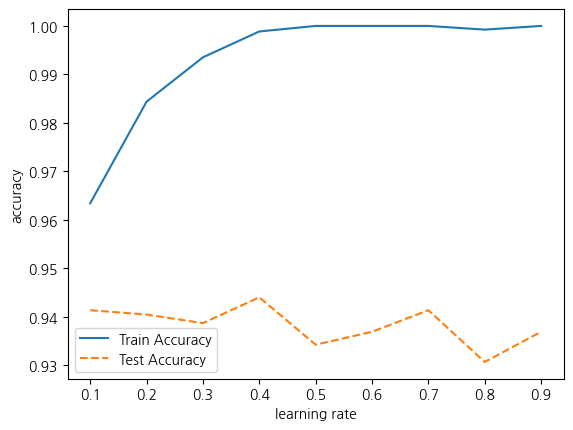

In [76]:
#모델로 정확도 확인
df_accuracy_lr.round(3)
plt.plot(para_lr, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_lr, test_accuracy, linestyle = '--', label = 'Test Accuracy')
plt.ylabel('accuracy') ; plt.xlabel('learning rate')
plt.legend()

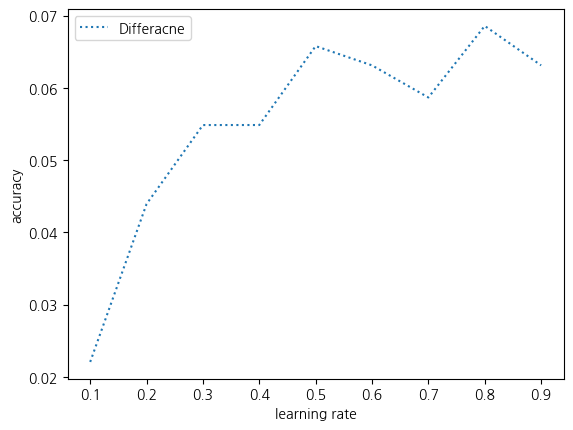

In [77]:
plt.plot(para_lr, differance, linestyle = ':', label = 'Differacne')
plt.ylabel('accuracy') ; plt.xlabel('learning rate')
plt.legend()

## 2.3 n_estimators : 트리 수 변경에 따른 모델 성능

In [16]:
train_accuracy = []; test_accuracy = []

para_n_tree = [n_tree*10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingClassifier(n_estimators= v_n_estimators,learning_rate = 0.6, random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n['Estimators'] = para_n_tree
df_accuracy_n['TrainAccuracy'] = train_accuracy
df_accuracy_n['TestAccuracy'] = test_accuracy

In [17]:
# 모델 정확도 확인
df_accuracy_n.head()

,Estimators,TrainAccuracy,TestAccuracy
0,10,0.932901,0.928000
1,20,0.939001,0.931556
2,30,0.947007,0.936000
3,40,0.951582,0.939556
4,50,0.955776,0.939556


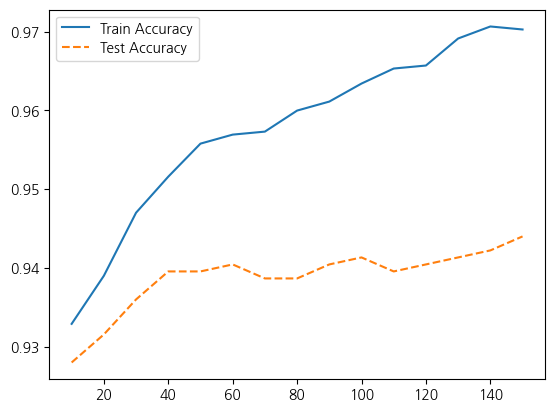

In [18]:
plt.plot(para_n_tree, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_n_tree, test_accuracy, linestyle = '--', label = 'Test Accuracy')
plt.legend()

### 2.4 max_depth : 최대 깊이 변경에 따른 모델 성능

In [19]:
# train, test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

# min_samples_split
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    gb = GradientBoostingClassifier(max_depth = v_max_depth,learning_rate = 0.1, n_estimators = 100, random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
#데이텉 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainAccuracy'] = train_accuracy
df_accuracy_depth['TestAccuracy'] = test_accuracy

In [20]:
#모델로 정확도 확인
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.936,0.935
1,2,0.951,0.940
2,3,0.963,0.941
3,4,0.979,0.945
4,5,0.990,0.940
5,6,0.998,0.950
6,7,1.000,0.947
7,8,1.000,0.948
8,9,1.000,0.948
9,10,1.000,0.947


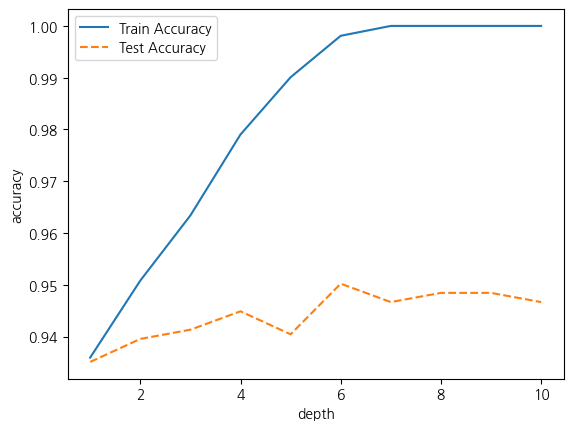

In [21]:
plt.plot(para_depth, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_depth, test_accuracy, linestyle = '--', label = 'Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('depth')
plt.legend()

### 2.5 min_samples_split : 분리노드의 최소 자료 수 변경에 따른 모델 성능

In [22]:
# train, test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

# min_samples_split
para_split = [n_split*10 for n_split in range(2,11)]

for v_min_samples_split in para_split:
    gb = GradientBoostingClassifier(min_samples_split = v_min_samples_split, max_depth = 6, n_estimators = 100, learning_rate = 0.1, random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
#데이텉 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split['MinSamplesSplit'] = para_split
df_accuracy_split['TrainAccuracy'] = train_accuracy
df_accuracy_split['TestAccuracy'] = test_accuracy

In [23]:
# 모델 정확도 확인
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,20,0.995,0.942
1,30,0.994,0.940
2,40,0.992,0.945
3,50,0.992,0.942
4,60,0.989,0.947
5,70,0.988,0.943
6,80,0.986,0.944
7,90,0.987,0.945
8,100,0.984,0.944


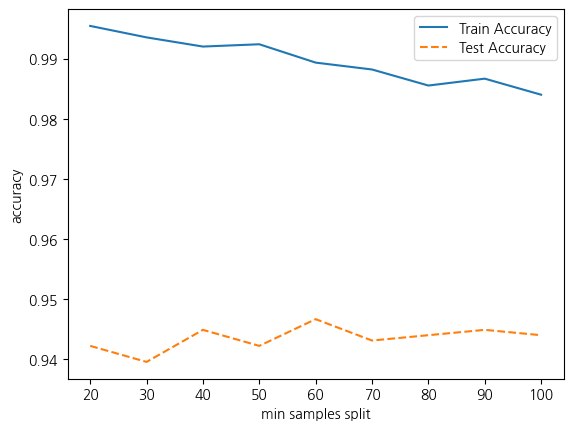

In [24]:
#모델로 정확도 확인
plt.plot(para_split, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_split, test_accuracy, linestyle = '--', label = 'Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('min samples split')
plt.legend()

### 2.6 min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [25]:
# train, test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

# min_samples_split
para_leaf = [n_leaf*5 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingClassifier(min_samples_leaf = v_min_samples_leaf, max_depth = 6, n_estimators = 100, learning_rate = 0.1, random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
#데이텉 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['MinSamplesLeaf'] = para_leaf
df_accuracy_leaf['TrainAccuracy'] = train_accuracy
df_accuracy_leaf['TestAccuracy'] = test_accuracy

In [26]:
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,5,0.998,0.943
1,10,0.995,0.948
2,15,0.991,0.949
3,20,0.990,0.948
4,25,0.987,0.945
5,30,0.984,0.943
6,35,0.984,0.943
7,40,0.982,0.944
8,45,0.982,0.943
9,50,0.978,0.943


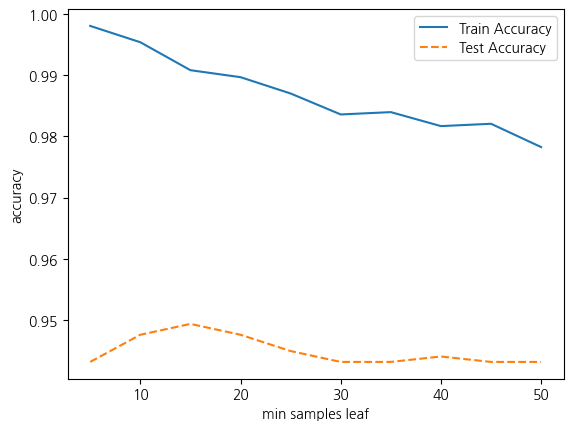

In [27]:
#모델로 정확도 확인
plt.plot(para_leaf, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_leaf, test_accuracy, linestyle = '--', label = 'Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('min samples leaf')
plt.legend()

### 2.7 결론 도출

In [28]:
gb_final = GradientBoostingClassifier(min_samples_leaf=15, max_depth=6, n_estimators=100, learning_rate=0.1,random_state = 1234)
gb_final.fit(df_train_x, df_train_y)
y_pred = gb_final.predict(df_test_x)
# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}\n".format(gb_final.score(df_test_x, df_test_y)))
#confusion matrix
print("Confusion matrix:{} \n".format(confusion_matrix(df_test_y, y_pred)))
#목표변수의 빈도 불균형 : f1 score로 모델 평가
print(classification_report(df_test_y, y_pred, digits=3))


Accuracy on training set: 0.991
Accuracy on test set: 0.949

Confusion matrix:[[1020    1]
 [  56   48]] 

              precision    recall  f1-score   support

           0      0.948     0.999     0.973      1021
           1      0.980     0.462     0.627       104

    accuracy                          0.949      1125
   macro avg      0.964     0.730     0.800      1125
weighted avg      0.951     0.949     0.941      1125



In [29]:
v_feature_name = df_train_x.columns
df_importance = pd.DataFrame()

df_importance['Feature'] = v_feature_name
df_importance['Importance'] = gb_final.feature_importances_
df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
9,DEBTINC,0.331
6,CLAGE,0.132
2,VALUE,0.105
5,DELINQ,0.096
8,CLNO,0.076
0,LOAN,0.069
3,YOJ,0.048
7,NINQ,0.041
1,MORTDUE,0.037
4,DEROG,0.035


Text(0, 0.5, '설명변수')

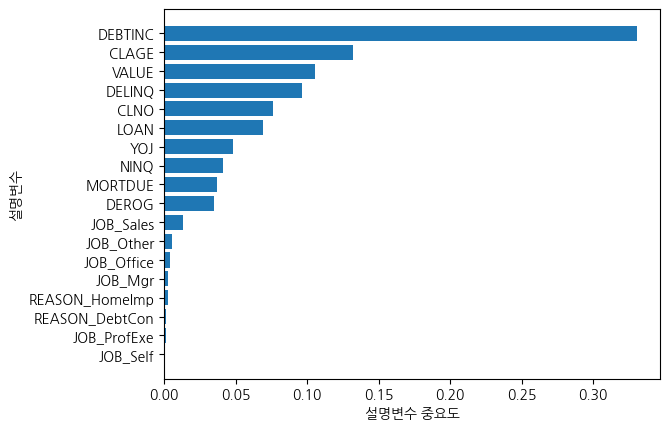

In [47]:
#설명변수 중요도 그래프
#중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len (df_importance ))
plt.barh(y = coordinates, width = df_importance ["Importance"])
plt.yticks(coordinates, df_importance ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

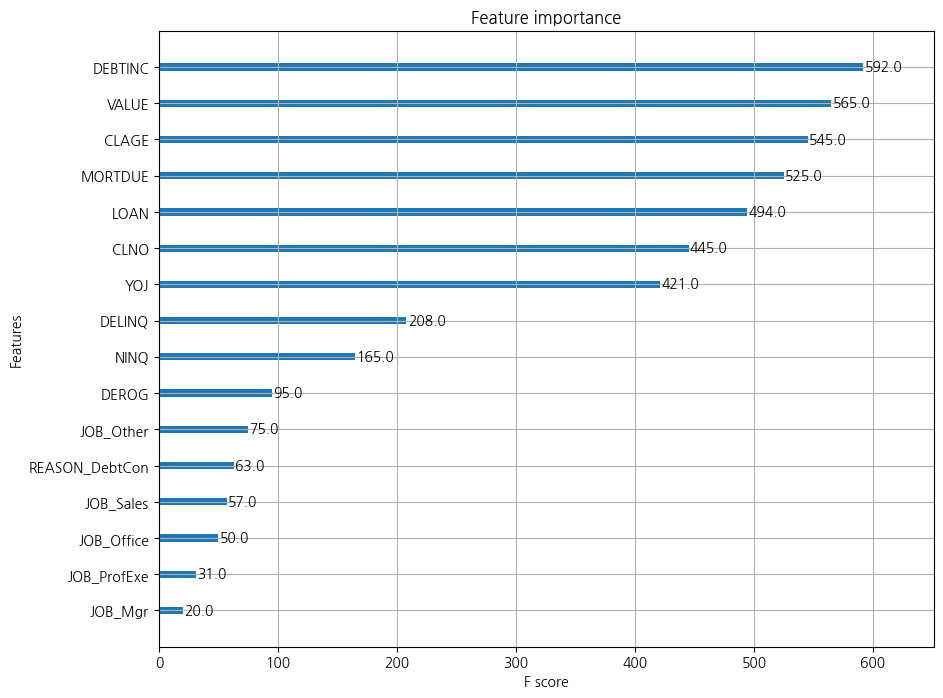

In [31]:
# estimator = GradientBoostingClassifier(n_estimators=100, random_state=1234)
# # 구하고자 하는 parameter와 범위
# param_grid = {"learning_rate": para_lr,
# "max_depth": para_depth,
# "min_samples_leaf": para_leaf}
# 2626262
# # 정확도가 높은 최적 parameter 찾기
# grid_gb = GridSearchCV(estimator, param_grid, scoring="accuracy", n_jobs = -1)
# grid_gb.fit(df_train_x, df_train_y)

# print("best estimator model: Wn".format(grid_gb.best_estimator_))
# print("Wnbest parameter: Wn".format(grid_gb.best_params_))
# print("Wnbest score: Wn{}".format(grid_gb.best_score_.round(3)))

# 3. 모델 생성- XGBoost

In [48]:
# !pip install xgboost

### 3.1 기본 옵션으로 모델 생성

In [35]:
#패키지 불러오기
from xgboost import XGBClassifier
#xgboost 패키지 불러오기
from xgboost import XGBClassifier
#변수 중요도 확인: F1 점수 기준
from xgboost import plot_importance
# 분류모델평가 함수
from sklearn.metrics import confusion_matrix,accuracy_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score,f1_score

In [36]:
# 분류모델 통합 평가: 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC
def eval_class_model(y_test, y_pred):
  confusion = confusion_matrix(y_test, y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  F1 = f1_score(y_test, y_pred)
  AUC = roc_auc_score(y_test, y_pred)
  print('오차행렬:₩n', confusion, '\n')
  print('정확도: {:.4f}'.format(accuracy))
  print('정밀도: {:4f}'.format(precision))
  print('재현율: {:4f}'.format(recall))
  print('F1:{:4f}'.format(F1))
  print('AUC : {:4f}'.format(AUC))

In [37]:
# 기본 모형 및 parameter 확인
xgboost_uncust = XGBClassifier()
xgboost_uncust

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)



### 3.2 다양한 hyper parameter 입력한 사용자 모델 개발 및 평가

In [50]:
# 모델 적합
xgboost_uncust.fit(df_train_x, df_train_y)
# 예측 및 모델 평가: train
print('\n 모델 생성 및 평가 : Train \n')
xgb_pred_train = xgboost_uncust.predict(df_train_x)
eval_class_model(df_train_y, xgb_pred_train)
# 예측 및 모델 평가 : test
print('\n 모델 생성 및 평가 \n')
xgb_pred_test=xgboost_uncust.predict(df_test_x)
eval_class_model(df_test_y, xgb_pred_test)


 모델 생성 및 평가 : Train 

오차행렬:₩n [[2382    0]
 [   0  241]] 

정확도: 1.0000
정밀도: 1.000000
재현율: 1.000000
F1:1.000000
AUC : 1.000000

 모델 생성 및 평가 

오차행렬:₩n [[1019    2]
 [  58   46]] 

정확도: 0.9467
정밀도: 0.958333
재현율: 0.442308
F1:0.605263
AUC : 0.720174


In [45]:
#사용자 모델 생성
xgboost_user= XGBClassifier(n_estimators = 100, learning_rate = 0.1, max_depth = 5)
#모델 적합
xgboost_user.fit(df_train_x, df_train_y)
# 예측 및 모델 평가:Train
xgb_pred_train = xgboost_user.predict(df_train_x)
print('\n 사용자 모델 평가 : Train \n')
eval_class_model(df_train_y, xgb_pred_train)
print('\n',classification_report(df_train_y, xgb_pred_train))
# 예측 및 모델 평가: Test
xgb_pred_test = xgboost_user.predict(df_test_x)
print('\n 사용자 모델 평가 : Test \n')
eval_class_model(df_test_y, xgb_pred_test)
print('\n',classification_report(df_test_y, xgb_pred_test))


 사용자 모델 평가 : Train 

오차행렬:₩n [[2382    0]
 [  49  192]] 

정확도: 0.9813
정밀도: 1.000000
재현율: 0.796680
F1:0.886836
AUC : 0.898340

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      2382
           1       1.00      0.80      0.89       241

    accuracy                           0.98      2623
   macro avg       0.99      0.90      0.94      2623
weighted avg       0.98      0.98      0.98      2623


 사용자 모델 평가 : Test 

오차행렬:₩n [[1020    1]
 [  63   41]] 

정확도: 0.9431
정밀도: 0.976190
재현율: 0.394231
F1:0.561644
AUC : 0.696626

               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1021
           1       0.98      0.39      0.56       104

    accuracy                           0.94      1125
   macro avg       0.96      0.70      0.77      1125
weighted avg       0.95      0.94      0.93      1125



### 3.3 조기중지 옵션 사용 모델 개발 및 평가

In [40]:
#오류함수의 평가지표:logloss
#조기중단을 위한 최소 반복횟수는 150
xgb_stop = XGBClassifier(n_estimators = 300, learning_rate = 0.1, max_depth = 6)
eval_df = [(df_test_x, df_test_y)]
xgb_stop.fit(df_train_x, df_train_y, early_stopping_rounds = 150,
eval_metric="logloss", eval_set = eval_df, verbose=True)

[0]	validation_0-logloss:0.62092
[1]	validation_0-logloss:0.56184
[2]	validation_0-logloss:0.51341
[3]	validation_0-logloss:0.47230
[4]	validation_0-logloss:0.43716
[5]	validation_0-logloss:0.40648
[6]	validation_0-logloss:0.38075
[7]	validation_0-logloss:0.35740
[8]	validation_0-logloss:0.33736
[9]	validation_0-logloss:0.32025
[10]	validation_0-logloss:0.30528
[11]	validation_0-logloss:0.29236
[12]	validation_0-logloss:0.28106
[13]	validation_0-logloss:0.27113
[14]	validation_0-logloss:0.26233
[15]	validation_0-logloss:0.25407
[16]	validation_0-logloss:0.24520
[17]	validation_0-logloss:0.23947
[18]	validation_0-logloss:0.23388
[19]	validation_0-logloss:0.22930
[20]	validation_0-logloss:0.22485
[21]	validation_0-logloss:0.22028
[22]	validation_0-logloss:0.21723
[23]	validation_0-logloss:0.21451
[24]	validation_0-logloss:0.21211
[25]	validation_0-logloss:0.20965
[26]	validation_0-logloss:0.20786
[27]	validation_0-logloss:0.20589
[28]	validation_0-logloss:0.20396
[29]	validation_0-loglos

/home/piai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/piai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-logloss:0.20047
[32]	validation_0-logloss:0.20027
[33]	validation_0-logloss:0.19930
[34]	validation_0-logloss:0.19902
[35]	validation_0-logloss:0.19800
[36]	validation_0-logloss:0.19692
[37]	validation_0-logloss:0.19629
[38]	validation_0-logloss:0.19585
[39]	validation_0-logloss:0.19575
[40]	validation_0-logloss:0.19473
[41]	validation_0-logloss:0.19445
[42]	validation_0-logloss:0.19447
[43]	validation_0-logloss:0.19413
[44]	validation_0-logloss:0.19427
[45]	validation_0-logloss:0.19340
[46]	validation_0-logloss:0.19326
[47]	validation_0-logloss:0.19208
[48]	validation_0-logloss:0.19208
[49]	validation_0-logloss:0.19181
[50]	validation_0-logloss:0.19102
[51]	validation_0-logloss:0.19055
[52]	validation_0-logloss:0.19050
[53]	validation_0-logloss:0.19086
[54]	validation_0-logloss:0.19073
[55]	validation_0-logloss:0.19130
[56]	validation_0-logloss:0.19120
[57]	validation_0-logloss:0.19116
[58]	validation_0-logloss:0.19089
[59]	validation_0-logloss:0.19063
[60]	validatio

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [41]:
#조기 중단 예측 및 모델 평가 : Test
xgb_pred_stop = xgb_stop.predict(df_test_x)
print('\n 조기 중단 모델 평가 : Test \n')
eval_class_model(df_test_y, xgb_pred_stop)
print('\n',classification_report(df_test_y, xgb_pred_stop))


 조기 중단 모델 평가 : Test 

오차행렬:₩n [[1020    1]
 [  62   42]] 

정확도: 0.9440
정밀도: 0.976744
재현율: 0.403846
F1:0.571429
AUC : 0.701433

               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1021
           1       0.98      0.40      0.57       104

    accuracy                           0.94      1125
   macro avg       0.96      0.70      0.77      1125
weighted avg       0.95      0.94      0.93      1125



### 3.4 설명변수의 중요도 확인 : plot_importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

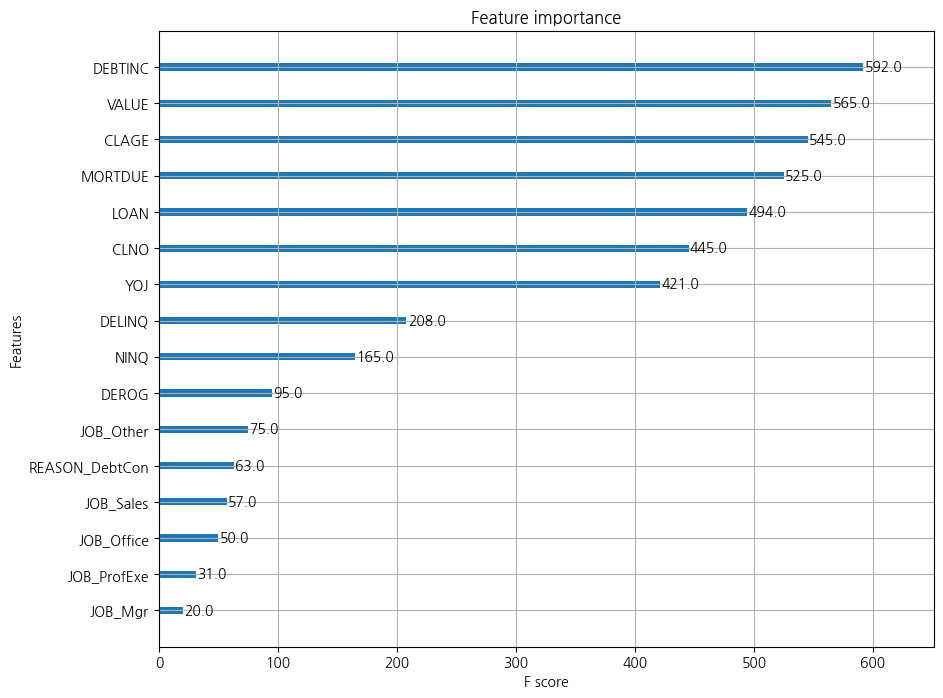

In [46]:
# 변수 중요도 확인
from xgboost import plot_importance 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,8))
plot_importance(xgb_stop, ax = ax)